# Final project DL4CV
# CMS4CV - Vanilla UNet

## Task:
## Historical image Recoloring and Super-Resolution


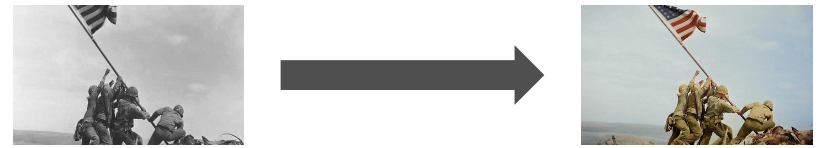


## Data:

1.   https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset/data
2.   https://www.kaggle.com/datasets/rahulrwl/landscape-images/data
3.   https://www.kaggle.com/datasets/medsalimaissi/similarity-dataset (selected images for zero-shot inference: https://www.kaggle.com/datasets/pierluigimancinelli/landscape-historical-images)

## Execution:
1. Written and optimized to run on Kaggle, running on Colab requires dataset download and path adjustments
2. Trained model filename: **UNet_Vanilla.keras**

# Imports

In [ ]:
# Set seed for reproducibility
seed = 123
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

#miscellanea - Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd #SEE IF YOU CAN INSTALL MODIN
import random
from PIL import Image
from keras import backend as K
import logging
import sys
from collections import defaultdict
from tqdm import tqdm
import cv2

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow and Numpy
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

np.random.seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# ⏳ Load & Transform Data

*   Noise injection
*   Gaussian Blurring
*   Downscaling  
*   Gray-scale mapping

#### First dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download("hsankesara/flickr-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr-image-dataset


In [ ]:
image_folder = path + "/flickr30k_images/flickr30k_images/flickr30k_images/"

In [ ]:
image_df = pd.read_csv(path + "/flickr30k_images/flickr30k_images/results.csv", sep="|")

In [ ]:
# column re-naming
image_df['comment_number'] = image_df[' comment_number']
image_df['comment'] = image_df[' comment']

In [ ]:
# row filtering to keep unique image names
image_names = image_df.image_name.unique()

#### Second dataset

In [ ]:
path2 = kagglehub.dataset_download("rahulrwl/landscape-images")
print("Path to dataset files:", path2)

Path to dataset files: /kaggle/input/landscape-images


In [ ]:
folder_path = path2 + '/images'
folder_path

'/kaggle/input/landscape-images/images'

In [ ]:
import requests
import io
# ulr containing the paths to the images selected for being in the dataset, as explained in DataAppendix notebook

image_name_url = "https://github.com/fabiosacerdote/Deep-Learning-for-Image-Restoration-CMS4CV/raw/refs/heads/main/image_paths.npy"

response = requests.get(image_name_url)
response.raise_for_status()
colab_image_paths = np.load(io.BytesIO(response.content), allow_pickle=True)

In [ ]:
kaggle_image_paths = []
df_1_paths = []
df_2_paths = []

for i in tqdm(range(len(colab_image_paths))):
    parts = colab_image_paths[i].split("/")
    if parts[5] == "hsankesara":
        fixed = image_folder + parts[-1]
        df_1_paths.append(fixed)
        #continue
    else:
        fixed = folder_path + "/" + parts[-1]
        df_2_paths.append(fixed)
    kaggle_image_paths.append(fixed)


df_1_paths = np.array(df_1_paths)
df_2_paths = np.array(df_2_paths)
#image_paths = np.array(kaggle_image_paths)

100%|██████████| 37142/37142 [00:00<00:00, 809490.56it/s]


In [ ]:
how_many = 4000 # per each dataset
batch = 16
input_dimension = 128

rng = np.random.default_rng(seed)
# Shuffle the array in a reproducible way
df_1_paths = rng.permutation(df_1_paths)
df_2_paths = rng.permutation(df_2_paths)

image_paths = np.concatenate([df_1_paths[:0], df_2_paths])

print(f'Datasets combined to create a list of {len(image_paths)} images')

Datasets combined to create a list of 5589 images


In [ ]:
# auxiliary functions to apply grey scaling, noise and blurring
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))


def add_grain_tf(image, intensity=0.5):
    """Adds grain to an image using TensorFlow.

    Args:
        image: A TensorFlow tensor representing the image.
        intensity: The intensity of the grain (default: 0.5). This should make the images resamble historical images

    Returns:
        A TensorFlow tensor with added grain.
    """

    image = tf.cast(image, dtype=tf.float32)
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=intensity, dtype=image.dtype)
    grainy_image = tf.add(image, noise)
    grainy_image = tf.cast(grainy_image, tf.float32)


    #noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=intensity, dtype=image.dtype)
    #grainy_image = tf.add(image, noise)
    return grainy_image


def auxiliary_functions(image, intensity = 1):
  image_np = image.numpy().astype("float32")

  # Add noise
  #image_np = add_grain_tf(image_np, intensity).numpy()

  # Blur image
  image_np = cv2.GaussianBlur(image_np, (5, 5), 0)

  # Downscale by a factor of 2
  height, width = image_np.shape[:2]
  image_np = cv2.resize(image_np, (input_dimension, input_dimension), interpolation=cv2.INTER_AREA)

  # Gray scaling
  image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

  # Histogram Equalization (CLAHE)
  image_np = clahe.apply(image_np.astype("uint8")).astype("float32")

  # Normalize
  image_np /= 255

  # Add channel dimension for TensorFlow
  image_np = image_np[..., np.newaxis]
  return tf.convert_to_tensor(image_np, dtype=tf.float32)

def auxiliary_functions_output(image):
  image_np = image.numpy()

  image_np = cv2.resize(image_np, (input_dimension*2, input_dimension*2), interpolation=cv2.INTER_AREA)

  # Add channel dimension for TensorFlow
  #image_np = image_np[..., np.newaxis]
  return tf.convert_to_tensor(image_np, dtype=tf.float32)

# Parse image with added custom effects
def parse_image(file_path, width, height, type = 'train'):
  '''
  Function to parse images, add transformations and cast them to tf.Dataset.
  Args:
    - file_path: path to the image
    - width: width of the image
    - height: height of the image
    - type: either 'train' or any other str. Used to distinguish between model inputs and predictions
  Returns:
    - image: parsed and transformed image
  '''
  # Read image
  image = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image, channels=3)

  if type == 'train':
    ## TO CHECK
    # Apply random horizontal flip
    #image = tf.image.random_flip_left_right(image)

    # Apply auxiliary transformations (grain/noise, blur, downscale, grayscale)
    image = tf.py_function(
        auxiliary_functions,
        [image],
        Tout=tf.float32)

    # ensure the image has been correctly downsampled
    image.set_shape([input_dimension, input_dimension, 1])

  else:
    # Ensure the shape is maintained
    image = tf.py_function(
        auxiliary_functions_output,
        [image],
        Tout=tf.float32)

    image.set_shape([input_dimension*2, input_dimension*2, 3])  # 1 channel for original image

  # set image type to float32
  image = tf.cast(image, tf.float32)
  return image

### Train test split

In [ ]:
# Split percentages
train_split = 0.8  # 80% training
test_split = 0.2   # 20% testing

# Compute sizes
dataset_size = len(image_paths)
train_size = int(train_split * dataset_size)

rng = np.random.default_rng(seed)

# Shuffle the array in a reproducible way
image_paths = rng.permutation(image_paths)

dataset_input = tf.data.Dataset.from_tensor_slices(image_paths[:train_size])
dataset_input = dataset_input.map(lambda x: parse_image(x, input_dimension*2, input_dimension*2))
dataset_input = dataset_input.batch(batch_size = batch)

dataset = tf.data.Dataset.from_tensor_slices(image_paths[:train_size])
dataset = dataset.map(lambda x: parse_image(x, input_dimension*2, input_dimension*2, type = 'output'))
dataset = dataset.batch(batch_size = batch)

# Combine datasets into (grayscale, color) pairs
dataset_final = tf.data.Dataset.zip((dataset_input, dataset))

for grayscale, color in dataset_final.take(1):
    print(f"Grayscale Image Shape: {grayscale.shape}")
    print(f"Color Image Shape: {color.shape}")

train_dataset = dataset_final.prefetch(tf.data.AUTOTUNE)

Grayscale Image Shape: (16, 128, 128, 1)
Color Image Shape: (16, 256, 256, 3)


In [ ]:
dataset_input = tf.data.Dataset.from_tensor_slices(image_paths[train_size:])
dataset_input = dataset_input.map(lambda x: parse_image(x, input_dimension*2, input_dimension*2))
dataset_input = dataset_input.batch(batch_size = batch)

dataset = tf.data.Dataset.from_tensor_slices(image_paths[train_size:])
dataset = dataset.map(lambda x: parse_image(x, input_dimension*2, input_dimension*2, type = 'output'))
dataset = dataset.batch(batch_size = batch)

# Combine datasets into (grayscale, color) pairs
dataset_test = tf.data.Dataset.zip((dataset_input, dataset))

for grayscale, color in dataset_test.take(1):
    print(f"Grayscale Image Shape: {grayscale.shape}")
    print(f"Color Image Shape: {color.shape}")

test_dataset = dataset_test.prefetch(tf.data.AUTOTUNE)

Grayscale Image Shape: (16, 128, 128, 1)
Color Image Shape: (16, 256, 256, 3)


In [ ]:
del dataset_final, dataset_test

# Architecture: Multitask

•⁠  I⁠⁠mage reconstruction with simple U-Net

•⁠  Image re-coloring with 3 channel output

•⁠  Image super-resolution adding an upscaling layer at the end

### Build a UNet

In [ ]:
input_shape = (input_dimension, input_dimension, 1)  # Grayscale input
print('Input shape',input_shape)

Input shape (128, 128, 1)


In [ ]:
import keras
def unet_block(input_tensor, filters, kernel_size=3, activation='lrelu', stack=1, name=''):

    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv'+str(i+1))(x)
        x = tfkl.BatchNormalization(name=name+'bn'+str(i+1))(x)
        if activation != 'relu':
            x = tfkl.LeakyReLU(alpha=0.2, name=name+'activation'+str(i+1))(x)
        else:
            x = tfkl.Activation(activation, name=name+'activation'+str(i+1))(x)

    return x

In [ ]:
def get_unet_model(input_shape=input_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling 256x256 -> 128x128
    down_block_1 = unet_block(input_layer, 64,stack=2, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    # Second Downsampling 128x128 -> 64x64
    down_block_2 = unet_block(d1, 128, stack=2, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Third Downsampling 64x64 -> 32x32
    down_block_3 = unet_block(d2, 256,stack=2, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Fourth Downsampling 32x32 -> 16x16
    down_block_4 = unet_block(d3, 512,stack=2, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Fifth Downsampling 16x16 -> 8x8
    down_block_5 = unet_block(d4, 1024, stack=2, name='down_block5_')
    d5 = tfkl.MaxPooling2D()(down_block_5)

    # Bottleneck
    bottleneck = unet_block(d5, 1024, name='bottleneck')

    # First Upsampling 16x16 -> 32x32
    u0 = tfkl.UpSampling2D()(bottleneck)
    u0 = tfkl.Add(name='add0')([u0,down_block_5]) # connection with down block before bottleneck
    u0 = unet_block(u0, 512, name='up_block0_' )

    # First Upsampling 16x16 -> 32x32
    u1 = tfkl.UpSampling2D()(u0)
    u1 = tfkl.Add(name='add1')([u1,down_block_4]) # connection with 2 down blocks before bottleneck
    u1 = unet_block(u1, 256, name='up_block1_')

    # Second Upsampling 32x32 -> 64x64
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Add(name='add2')([u2,down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    # Third Upsampling 64x64 -> 128x128
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Add(name='add3')([u3,down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    # Forth Upsampling 128x128 -> 256x256
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Add(name='add4')([u4,down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    #SUPER RESOLUTION PART
    # Fifth Upsampling 256x256 -> 512x512
    u5 = tfkl.UpSampling2D()(u4)
    #u5 = tfkl.Add(name='add5')([u5,down_block_1]) #TODO: try
    u5 = unet_block(u5, 32, name='up_block5_')

    # Output Layer
    #NB: num_classes = 3, R G B
    output_layer = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation="sigmoid", name='output_layer')(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 1)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 128,     │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 128,     │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 128,     │         0 │ down_block1_b… │   -   │
│ (LeakyReLU)       │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 128,     │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 128,     │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 128,     │         0 │ down_block1_b… │   -   │
│ (LeakyReLU)       │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 64, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 64, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 64, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 64, 64,  │         0 │ down_block2_b… │   -   │
│ (LeakyReLU)       │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 64, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 64, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 64, 64,  │         0 │ down_block2_b… │   -   │
│ (LeakyReLU)       │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 32, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 32, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 32, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 34,628,547 (132.10 MB)

 Trainable params: 34,616,451 (132.05 MB)

 Non-trainable params: 12,096 (47.25 KB)

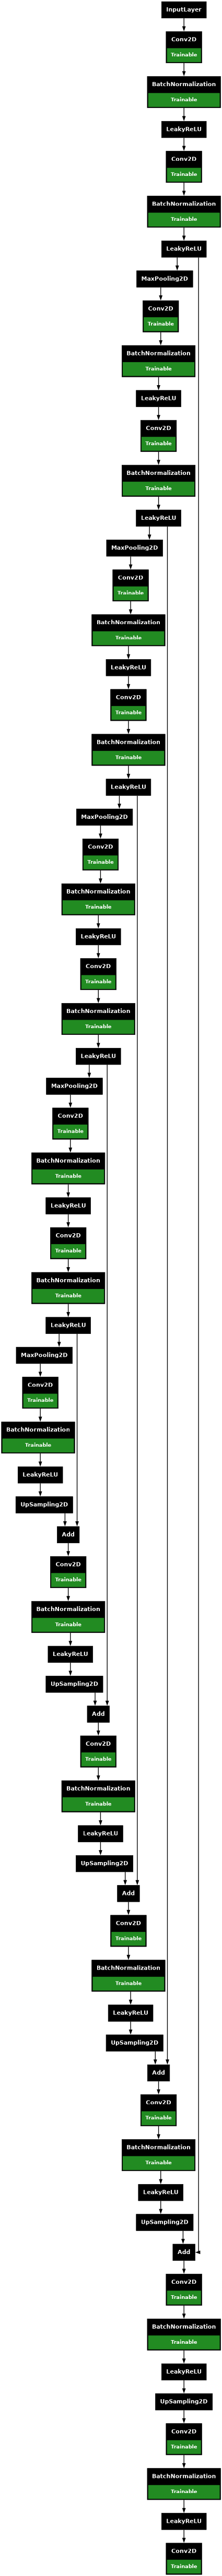

In [ ]:
model = get_unet_model()
model.summary(expand_nested=True, show_trainable=True)
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=50)

Custom Callbacks

In [ ]:
class SSIM(tf.keras.metrics.Metric):
  def __init__(self, name="SSIM", **kwargs):
    super(SSIM, self).__init__(name=name, **kwargs)
    self.total_ssim = self.add_weight(name="total_ssim", initializer="zeros")
    self.count = self.add_weight(name="count", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true_float = tf.image.convert_image_dtype(y_true, tf.float32)
    y_pred_float = tf.image.convert_image_dtype(y_pred, tf.float32)

    ssim_value = tf.image.ssim(y_true_float/255., y_pred_float, max_val=1.0)
    self.total_ssim.assign_add(tf.reduce_sum(ssim_value))
    self.count.assign_add(tf.cast(tf.size(ssim_value), tf.float32))

  def result(self):
    return self.total_ssim / self.count

  def reset_state(self):
    self.total_ssim.assign(0.0)
    self.count.assign(0.0)

class PSNR(tf.keras.metrics.Metric):
    def __init__(self, name="PSNR", **kwargs):
        super(PSNR, self).__init__(name=name, **kwargs)
        self.total_psnr = self.add_weight(name="total_psnr", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert image dtype to float32 and normalize to [0, 1] if necessary
        y_true_float = tf.image.convert_image_dtype(y_true, tf.float32)
        y_pred_float = tf.image.convert_image_dtype(y_pred, tf.float32)

        # Calculate PSNR
        psnr_value = tf.image.psnr(y_pred_float*255, y_true_float,  max_val=255.0)

        # Update the state variables
        self.total_psnr.assign_add(tf.reduce_sum(psnr_value))
        self.count.assign_add(tf.cast(tf.size(psnr_value), tf.float32))

    def result(self):
        return self.total_psnr / self.count

    def reset_state(self):
        self.total_psnr.assign(0.0)
        self.count.assign(0.0)

class MeanCIEDE2000(tf.keras.metrics.Metric):
    def __init__(self, name='mean_ciede2000', **kwargs):
        super(MeanCIEDE2000, self).__init__(name=name, **kwargs)
        self.total_ciede2000 = self.add_weight(name='total_ciede2000', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert image dtype to float32 and normalize to [0, 1] if necessary
        y_true_float = tf.image.convert_image_dtype(y_true, tf.float32)
        y_pred_float = tf.image.convert_image_dtype(y_pred, tf.float32)

        def compute_ciede2000(y_true_np, y_pred_np):
            batch_ciede2000 = []
            for true_img, pred_img in zip(y_true_np, y_pred_np):
                # Convert RGB to LAB
                true_lab = color.rgb2lab(true_img)
                pred_lab = color.rgb2lab(pred_img)

                # Reshape to (num_pixels, 3)
                true_lab = true_lab.reshape(-1, 3)
                pred_lab = pred_lab.reshape(-1, 3)

                # Compute CIEDE2000 for each pixel
                ciede2000_diff = color.deltaE_ciede2000(true_lab/255., pred_lab)

                # Compute mean CIEDE2000 for the image
                mean_ciede2000 = np.mean(ciede2000_diff)
                batch_ciede2000.append(mean_ciede2000)

            batch_ciede2000 = np.array(batch_ciede2000)
            return np.sum(batch_ciede2000), len(batch_ciede2000)

        # Use tf.py_function to wrap the NumPy computation
        total_ciede2000, batch_count = tf.py_function(
            func=compute_ciede2000,
            inp=[y_true, y_pred],
            Tout=[tf.float32, tf.int32]
        )

        # Update state
        self.total_ciede2000.assign_add(total_ciede2000)
        self.count.assign_add(tf.cast(batch_count, tf.float32))

    def result(self):
        return self.total_ciede2000 / self.count

    def reset_state(self):
        self.total_ciede2000.assign(0.0)
        self.count.assign(0.0)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):
  def __init__(self, image, label, interval=1):
    """
    Visualization Callback to display model predictions during training.

    Args:
        image: Input grayscale image(s) to pass through the model.
        label: Ground truth color image(s) for comparison.
        interval: Frequency (in epochs) to trigger visualization.
    """
    super().__init__()
    self.image = image
    self.label = label
    self.interval = interval

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.interval == 0:
      # Extract and reshape a single image from the batch
      image_data = next(iter(self.image))
      label_data = next(iter(self.label))

      pred = self.model.predict(image_data[0], verbose=0)
      fig, axes = plt.subplots(1, 3, figsize=(18, 6))

      # Original grayscale image
      axes[0].imshow(tf.squeeze(image_data[0][0]*255), cmap="gray")
      axes[0].set_title("Input Grayscale Image")
      axes[0].axis("off")

      # Predicted color image
        #Linear:
      #pred_clipped = tf.clip_by_value(pred[0], 0, 255)  # Ensure values are in [0, 1]
      #axes[1].imshow(tf.squeeze(pred_clipped).numpy().astype('uint8'))
        #Sigmoid:
      axes[1].imshow((tf.squeeze(pred[0]).numpy()*255).astype('uint8'))
      axes[1].set_title("Predicted Color Image")
      axes[1].axis("off")

      # Ground truth color image
      axes[2].imshow(tf.squeeze(label_data[0][0]).numpy().astype('uint8'))
      axes[2].set_title("Ground Truth Color Image")
      axes[2].axis("off")

      plt.tight_layout()
      plt.show()

# Set up a checkpoint directory
#checkpoint_dir = './checkpoints'
#checkpoint_filepath = checkpoint_dir + '/model-{epoch:02d}-{val_loss:.2f}.weights.h5'

# Create a callback for saving the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoints/best_model.weights.h5',
    save_weights_only=True,  # Save only the weights, not the full model
    monitor='val_loss',      # Monitor validation loss
    mode='min',              # Save weights when 'val_loss' is minimized
    save_best_only=True)

# Training

In [ ]:
def sigmoid_mse(y_true, y_pred):
  """Custom MSE loss with output rescaling.

  Args:
    y_true: True target values.
    y_pred: Predicted values.

  Returns:
    MSE loss.
  """
  # Normalize between 0-255
  y_pred_adjusted = y_pred*255
  # Calculate MSE between true and clipped predicted values
  mse = tf.keras.losses.mse(y_true, y_pred_adjusted)
  return mse

def sigmoid_mae(y_true, y_pred):
  """Custom MAE loss with output rescaling.

  Args:
    y_true: True target values.
    y_pred: Predicted values.

  Returns:
    MAE loss.
  """
  # Normalize between 0-255
  y_pred_adjusted = y_pred
  # Calculate MAE between true and clipped predicted values
  mae = tf.keras.losses.mae(y_true/255.0, y_pred_adjusted)
  return mae


def SSIM_loss(y_true, y_pred):
    y_pred_adjusted = y_pred

    ssim_value = tf.image.ssim(y_true/255.0, y_pred_adjusted, max_val=1.0)

    return tf.reduce_mean(1 - ssim_value) #so is a loss

def SSIM_mae_loss(y_true, y_pred):
    alpha = 0.8
    beta = 0.2
    return alpha*sigmoid_mae(y_true, y_pred) + beta*SSIM_loss(y_true, y_pred)

def PSNR_loss(y_true, y_pred):
    y_pred_adjusted = y_pred*255

    psnr_value = tf.image.psnr(y_true, y_pred_adjusted, max_val=255.0)

    return tf.reduce_mean(1 / (psnr_value + 1e-8) ) # Avoid division by zero

def combined_loss(y_true, y_pred):
    return sigmoid_mae(y_true, y_pred) + 10*SSIM_loss(y_true, y_pred) + PSNR_loss(y_true, y_pred)

In [ ]:
learning_rate = 1e-5
model.compile(
    loss = SSIM_mae_loss,
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics = [PSNR(), SSIM()])

In [ ]:
def schedule(current_epoch, current_lr):
    if current_epoch <= 2:
        return 1e-2
    elif current_epoch > 2 and current_epoch <= 4:
        return 1e-3
    elif current_epoch > 4 and current_epoch <= 6:
        return 1e-4
    else:
        return 1e-5

# Example image and label for visualization
example_image = dataset_input.take(1).map(lambda x: x).batch(1)
example_label = dataset.take(1).map(lambda x: x).batch(1)

# Visualization callback
#viz_callback = VizCallback(image=example_image, label=example_label, interval=50)

patience = 5
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True, min_delta = 1e-3)
viz_callback = VizCallback(example_image, example_label, interval = 3)

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)

In [ ]:
user_input = input("Do you want to train the model from scratch? (yes/no): ").strip().lower()
if user_input in ['yes', 'y']:
    print("Starting training from scratch...")
    # Train the U_net model on the dataset with specified parameters

    history = model.fit(
        x=train_dataset,
        epochs=15,
        validation_data = test_dataset,
        callbacks = [early_stopping,
                     viz_callback,
                     #scheduler,
                     checkpoint_callback]
)

else:
    print("Loading existing weights")
    model.load_weights('UNet_Vanilla.keras') # 14 Epochs completed

Do you want to train the model from scratch? (yes/no):  no


Loading existing weights


In [ ]:
'''
# Function to check if best weights after training are correctly saved
for root, dirnames, fnames in os.walk('checkpoints'):
    for fname in fnames:
        print(os.path.join(root, fname))

model.load_weights('checkpoints/best_model.weights.h5')
'''

In [ ]:
how_many = 16

example_images = dataset_input.take(10).map(lambda x: x).batch(16)
example_labels = dataset.take(10).map(lambda x: x).batch(16)

image_data = next(iter(example_images))
label_data = next(iter(example_labels))

b = 0
pred = model.predict(image_data[b], verbose=0)

I0000 00:00:1733263111.185473      95 service.cc:145] XLA service 0x7a3db401a2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733263111.185531      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733263115.882400      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


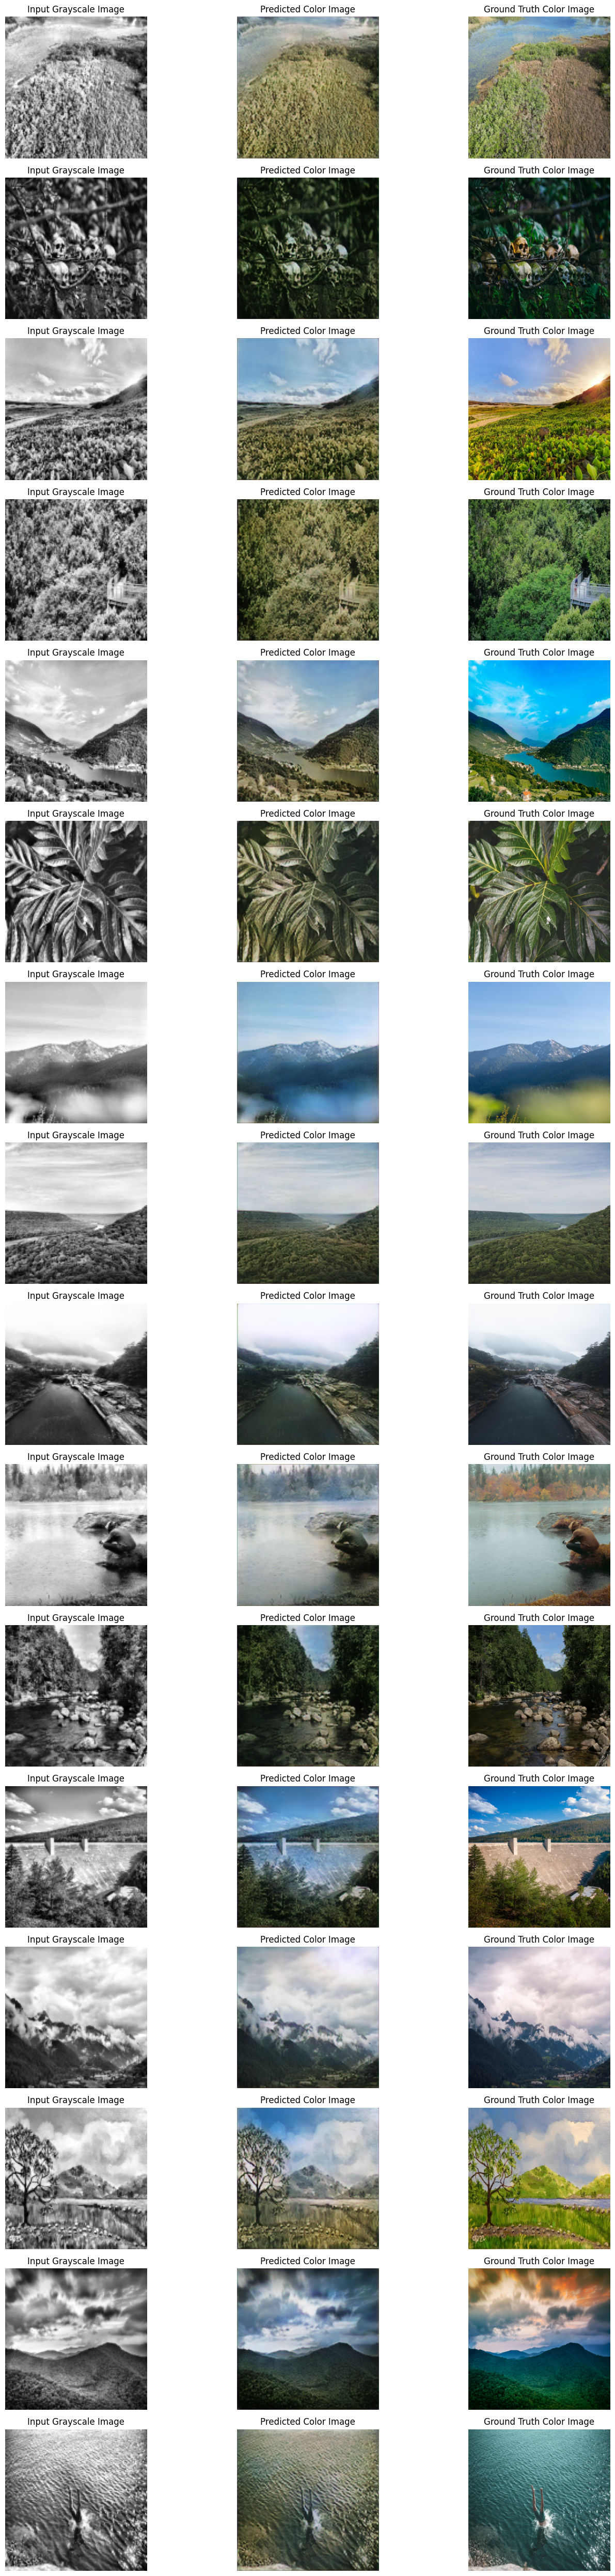

In [ ]:
fig, axes = plt.subplots(how_many, 3, figsize=(15, 50))

for i in range(how_many):

  # Original grayscale image
  axes[i][0].imshow(tf.squeeze(image_data[b][i]*255), cmap="gray")
  axes[i][0].set_title("Input Grayscale Image")
  axes[i][0].axis("off")

  # Predicted color image
    #Linear:
  #pred_clipped = tf.clip_by_value(pred[0], 0, 255)  # Ensure values are in [0, 1]
  #axes[1].imshow(tf.squeeze(pred_clipped).numpy().astype('uint8'))
    #Sigmoid:
  axes[i][1].imshow((tf.squeeze(pred[i]).numpy()*255).astype('uint8'))
  axes[i][1].set_title("Predicted Color Image")
  axes[i][1].axis("off")

  # Ground truth color image
  axes[i][2].imshow(tf.squeeze(label_data[b][i]).numpy().astype('uint8'))
  axes[i][2].set_title("Ground Truth Color Image")
  axes[i][2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
'''
best_epoch = np.argmax(history.history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('MAE')
plt.legend()
plt.grid(alpha=.3)
plt.show()
'''

In [ ]:
'''
plt.figure(figsize=(18,3))
plt.plot(history.history['PSNR'], label='Training PSNR', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_PSNR'], label='Validation PSNR', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Peak Signal-to-Noise Ratio (PSNR)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['SSIM'], label='Training SSIM', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_SSIM'], label='Validation SSIM', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Structural Similarity Index (SSIM)')
plt.legend()
plt.grid(alpha=.3)
plt.show()
'''

In [ ]:
model.save('UNet_Vanilla.keras')

In [ ]:
del model

In [ ]:
from skimage import color
# Initialize metrics
val_PSNR_metric = PSNR()
val_SSIM_metric = SSIM()
val_MAE_metric = tf.keras.metrics.MeanAbsoluteError()
val_CIEDE2000 = MeanCIEDE2000()

# Loop through validation dataset batches
for batch in tqdm(test_dataset):
    x_batch, y_batch = batch  # Unpack features and labels
    predictions = model(x_batch, training=False)  # Get predictions
    # Update metrics
    val_PSNR_metric.update_state(y_batch, predictions)
    val_SSIM_metric.update_state(y_batch, predictions)
    val_MAE_metric.update_state(y_batch/255.0, predictions)#PSNR() and SSIM() already account for /255
    val_CIEDE2000.update_state(y_batch, predictions)

# Compute final metric results
PSNR_value = val_PSNR_metric.result().numpy()
SSIM_value = val_SSIM_metric.result().numpy()
MAE_value = val_MAE_metric.result().numpy()
CIEDE2000_value = val_CIEDE2000.result().numpy()

print(f"Validation PSNR: {PSNR_value}")
print(f"Validation SSIM: {SSIM_value}")
print(f"Validation MAE: {MAE_value}")
print(f"Validation CIEDE2000: {CIEDE2000_value}")

100%|██████████| 70/70 [00:50<00:00,  1.38it/s]

Validation PSNR: 21.20094108581543
Validation SSIM: 0.7835347056388855
Validation MAE: 0.0665491372346878
Validation CIEDE2000: 24.414405822753906


In [ ]:
# Initialize metrics
val_PSNR_metric = PSNR()
val_SSIM_metric = SSIM()
val_MAE_metric = tf.keras.metrics.MeanAbsoluteError()

# Loop through validation dataset batches
for batch in tqdm(test_dataset):
    x_batch, y_batch = batch  # Unpack features and labels
    predictions = model(x_batch, training=False)  # Get predictions

    # Update metrics
    val_PSNR_metric.update_state(y_batch, predictions)
    val_SSIM_metric.update_state(y_batch, predictions)
    val_MAE_metric.update_state(y_batch/255.0, predictions)

# Compute final metric results
PSNR_value = val_PSNR_metric.result().numpy()
SSIM_value = val_SSIM_metric.result().numpy()
MAE_value = val_MAE_metric.result().numpy()

print(f"Validation PSNR: {PSNR_value}")
print(f"Validation SSIM: {SSIM_value}")
print(f"Validation MAE: {MAE_value}")

# Zero-Shot Historical Images

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pierluigimancinelli/landscape-historical-images")

print("Path to dataset files:", path)

csv_path = path + '/image_classification_labels.csv'
landscapes = pd.read_csv(csv_path )

def change_path(path):
    '''
    Function to align the paths from the imported dataset to the historical images ones
    '''
    x = path.split('/')
    x = x[9:]
    x = '/'.join(x)
    x = '/kaggle/input/similarity-dataset/' + x
    return x

landscapes.image_path = landscapes.image_path.apply(lambda x: change_path(x) )
landscapes = landscapes[landscapes.label == 1].image_path # get only images of landscapes
landscapes = np.array(landscapes)

def auxiliary_functions_output(image, intensity = 1):
  image_np = image.numpy()
  image_np = cv2.resize(image_np, (128, 128), interpolation=cv2.INTER_AREA) # not needed for U-Net

  # Histogram Equalization (CLAHE)
  image_np = clahe.apply(image_np.astype("uint8")).astype("float32")

  # Normalize
  image_np /= 255
  # Add channel dimension for TensorFlow
  image_np = image_np[..., np.newaxis]
  return tf.convert_to_tensor(image_np, dtype=tf.float32)

# Parse image with added custom effects
def parse_inference_image(file_path, width, height):
  '''
  Function to parse images, add transformations and cast them to tf.Dataset.
  Args:
    - file_path: path to the image
    - width: width of the image
    - height: height of the image
    - type: either 'train' or any other str. Used to distinguish between model inputs and predictions
  Returns:
    - image: parsed and transformed image
  '''
  # Read image
  image = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image, channels=1)

  # Apply
  image = tf.py_function(
      auxiliary_functions_output,
      [image],
      Tout=tf.float32)

  image.set_shape([128, 128, 1])

  # set image type to uint8
  image = tf.cast(image, tf.float32)
  return image

In [ ]:
image_filepaths = landscapes

batch = 16

dataset_hist = tf.data.Dataset.from_tensor_slices(image_filepaths)
dataset_hist = dataset_hist.map(lambda x: parse_inference_image(x, 128, 128))
dataset_hist = dataset_hist.batch(batch_size=batch)

print(f"Number of inference images gathered: {len(image_filepaths)}")
print(f"Dataset prepared with batch size: {batch}")

In [ ]:
for batch_images in dataset_hist.take(2):
    processed_image = batch_images.numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(tf.squeeze(processed_image[0]*255), cmap='gray')
    plt.title(f"Processed Image Shape: {processed_image.shape}")
    plt.axis('off')
    plt.show()

In [ ]:
how_many = 16

example_images = dataset_hist.take(10).map(lambda x: x).batch(8)

image_data = next(iter(example_images))

In [ ]:
b = 4# selected batch

pred = model.predict(image_data[b], verbose=0)


fig, axes = plt.subplots(how_many,2,  figsize=(15, 50))

for i in range(how_many):

  # Original grayscale image
  axes[i][0].imshow(tf.squeeze(image_data[b][i]*255), cmap="gray")
  axes[i][0].set_title("Input Grayscale Image")
  axes[i][0].axis("off")

  # Predicted color image
  axes[i][1].imshow((tf.squeeze(pred[i]).numpy()*255).astype('uint8'))
  axes[i][1].set_title("Predicted Color Image")
  axes[i][1].axis("off")


plt.tight_layout()
plt.show()